## AI/ML Session - 5th September 2024 (further practice notebook)
### By - Heta Rahul Patel
---

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

### Generate synthetic data & load into a dataframe

In [2]:
# Generate synthetic time series data
np.random.seed(42)
dates = pd.date_range(start='2024-06-01', periods=100)
trend = np.linspace(10, 30, 100)
seasonality = 10 * np.sin(np.linspace(0, 3 * np.pi, 100))
noise = np.random.normal(0, 2, 100)
data = trend + seasonality + noise

df = pd.DataFrame(data, index=dates, columns=['Value'])

## Plot the data

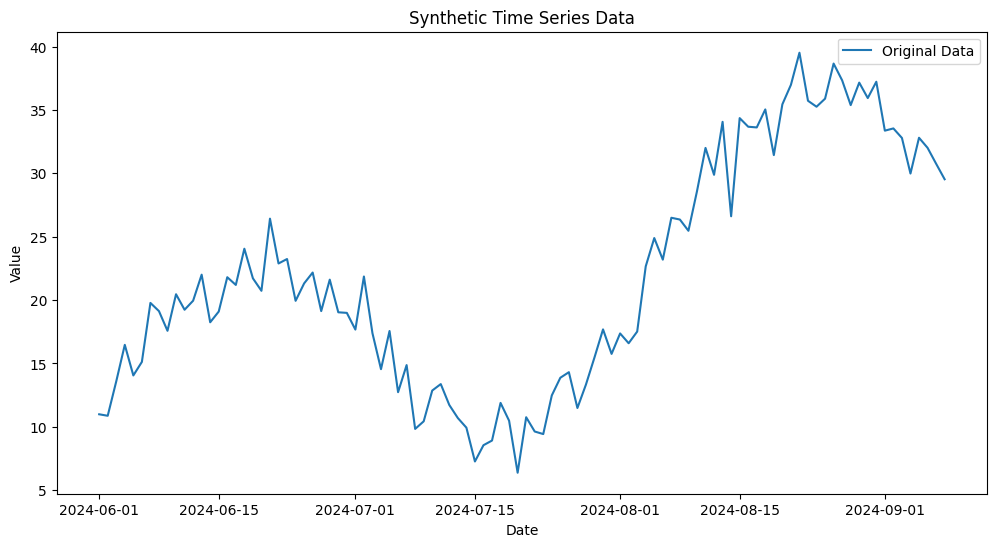

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df, label='Original Data')
plt.title('Synthetic Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [4]:
# Future prediction range
future_steps = 10
future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=future_steps)

## Moving Average

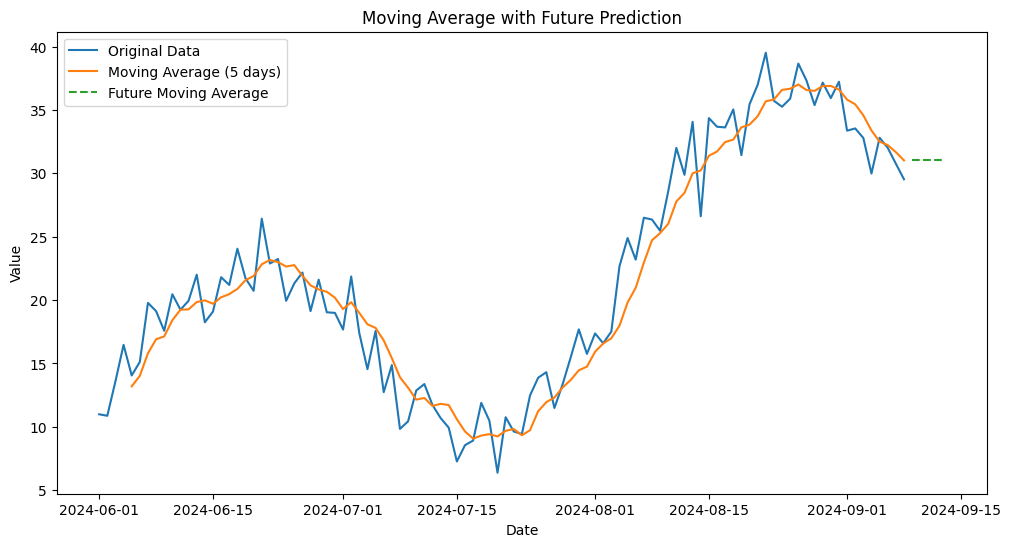

In [5]:
# Moving Average with Future Prediction
window_size = 5
df['Moving_Average'] = df['Value'].rolling(window=window_size).mean()

# Extend the moving average to predict future values
future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=5)
future_values = [df['Moving_Average'].iloc[-1]] * 5
future_df = pd.DataFrame(future_values, index=future_dates, columns=['Moving_Average'])

plt.figure(figsize=(12, 6))
plt.plot(df['Value'], label='Original Data')
plt.plot(df['Moving_Average'], label=f'Moving Average ({window_size} days)')
plt.plot(future_df, label='Future Moving Average', linestyle='--')
plt.title('Moving Average with Future Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## ARIMA

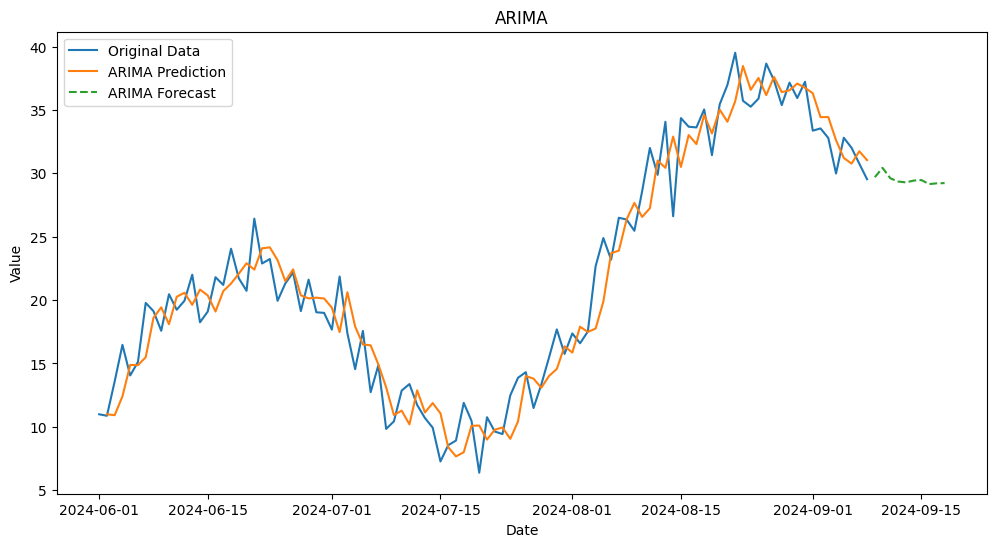

In [6]:
arima_model = ARIMA(df['Value'], order=(5, 1, 0))
arima_result = arima_model.fit()
df['ARIMA_Prediction'] = arima_result.predict(start=1, end=len(df), dynamic=False)
arima_forecast = arima_result.forecast(steps=future_steps)
future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=10)

plt.figure(figsize=(12, 6))
plt.plot(df['Value'], label='Original Data')
plt.plot(df['ARIMA_Prediction'], label='ARIMA Prediction')
plt.plot(future_dates, arima_forecast, label='ARIMA Forecast', linestyle='dashed')
plt.title('ARIMA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## Exponential Smoothing

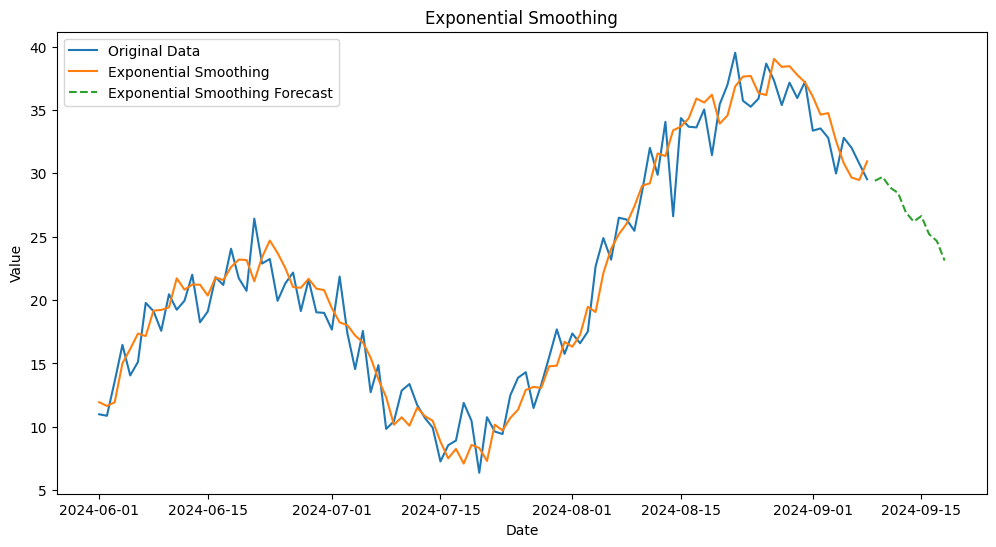

In [7]:
exp_model = ExponentialSmoothing(df['Value'], trend='add', seasonal='add', seasonal_periods=12)
exp_result = exp_model.fit()
df['Exponential_Smoothing'] = exp_result.fittedvalues
exp_forecast = exp_result.forecast(steps=future_steps)

plt.figure(figsize=(12, 6))
plt.plot(df['Value'], label='Original Data')
plt.plot(df['Exponential_Smoothing'], label='Exponential Smoothing')
plt.plot(future_dates, exp_forecast, label='Exponential Smoothing Forecast', linestyle='dashed')
plt.title('Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## LSTM (Long-Short Term Memory)

In [8]:
# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Value']])

In [9]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [10]:
# Create sequences of data
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 5
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

In [11]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Train the model
lstm_model.fit(x_train, y_train, batch_size=1, epochs=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0998


In [13]:
# Make predictions
train_predictions = lstm_model.predict(x_train)
test_predictions = lstm_model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [14]:
# Unscale the data
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

In [15]:
# Create a dataframe to compare predictions with actual data
train_df = df[:train_size].copy()
test_df = df[train_size + seq_length:].copy()

In [16]:
train_df['LSTM_Prediction'] = np.nan
test_df['LSTM_Prediction'] = np.nan

In [17]:
train_df['LSTM_Prediction'][seq_length:] = train_predictions[:, 0]
test_df['LSTM_Prediction'] = test_predictions[:, 0]

In [18]:
# Future prediction using LSTM
# Prepare last sequence for prediction
last_sequence = scaled_data[-seq_length:]
predicted_sequence = []

for i in range(future_steps):
    predicted_value = lstm_model.predict(last_sequence.reshape(1, seq_length, 1))
    predicted_sequence.append(predicted_value[0, 0])
    last_sequence = np.append(last_sequence[1:], predicted_value)[None].T

# Inverse scale the predictions
predicted_sequence = scaler.inverse_transform(np.array(predicted_sequence).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


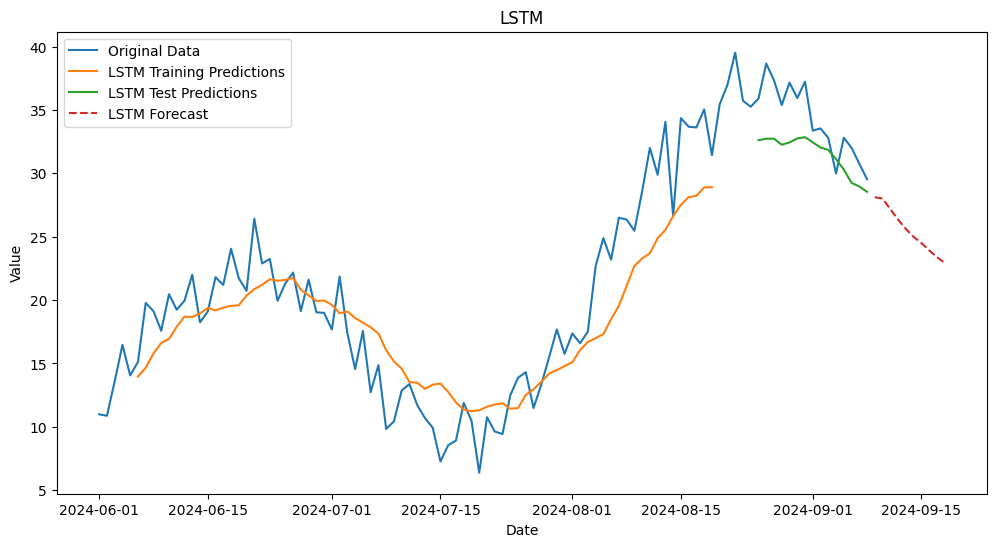

In [19]:
# Plot the LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Value'], label='Original Data')
plt.plot(train_df['LSTM_Prediction'], label='LSTM Training Predictions')
plt.plot(test_df['LSTM_Prediction'], label='LSTM Test Predictions')
plt.plot(future_dates, predicted_sequence, label='LSTM Forecast', linestyle='dashed')
plt.title('LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()